In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter,NullFormatter
import numpy as np
import pandas as pd
import os
import pymc3 as pm
import importlib
import pymc3_utils as pu    ; importlib.reload(pu);
import clonogenic_utils as cu; importlib.reload(cu);

# Read in the data

Read in the data from each plate run from `combined_results.csv` files.

In [5]:
from glob import glob
files=glob("analysis-strip/UWB1 pair/*/combined_results.csv")\
     +glob("analysis-strip/summary/*/combined_results.csv")
dfs=[]
for i,file in enumerate(files[:]):
    df = pd.read_csv(file)
    df['plate']=i
    dfs.append(df)
df = pd.concat(dfs,ignore_index=True)

Add indices to group by cell line, drug and (cell_line x drug )

In [6]:
df['i_exp'],df['exp_code']=pu.multilabel_encoder(df,'Cell_line Drug plate'.split(),delim='|')
df['i_cell'],_            =pu.multilabel_encoder(df,'Cell_line'.split(),delim='|')
df['i_drug'],_            =pu.multilabel_encoder(df,'Drug'.split(),delim='|')
df['i_drugcell'],_        =pu.multilabel_encoder(df,'Drug Cell_line'.split(),delim='|')

These are indices of that embed the various subgroups to the experimential data.

In [7]:
cell2ind     = pu.embeded_index(df,'i_exp','i_cell')
drug2ind     = pu.embeded_index(df,'i_exp','i_drug')
drugcell2ind = pu.embeded_index(df,'i_exp','i_drugcell')
drug2drugcell= pu.embeded_index(df,'i_drugcell','i_drug')

### Fit a single data set - logit transform


In [9]:
mask = df['i_exp']==5
dft=df[mask]
cells_plated = dft['Cells Plated'].values
concs        = dft['Treatment'].values
counts       = dft['Count'].values

with pm.Model() as plated_model:

    
    PE_a = pm.Lognormal("PE_a",2,0.2)
    PE_b = pm.Lognormal("PE_b",4,0.2)
    PE = pm.Beta("PE",alpha=PE_a,beta=PE_b)
    #PE = pm.Beta("PE",alpha=2,beta=4)#,shape=12)
    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE)

    # model coefficents
    alpha = pm.Lognormal('alpha',mu=np.log(0.1),sd=0.4)
    beta  = pm.Lognormal('beta', mu=np.log(0.01),sd=0.4)
 
    #nb_alpha = pm.HalfNormal('nb_alpha',0.02)

    model = pm.Deterministic('model',mu_attach*pm.math.exp(-alpha*concs-(beta*concs)**2))
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_alpha**2,observed=counts)
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [10]:
with plated_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, PE, PE_b, PE_a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2050.80draws/s]


### Fit whole dataset

In [12]:
exp_idx      = df['i_exp'].values; nexp   = max(exp_idx)+1
counts       = df['Count'].values; ncount = len(counts)
concs        = df['Treatment'].values
cells_plated = df['Cells Plated'].values
labels       = df['Experiment Title'].values

In [13]:
import theano.tensor as tt
with pm.Model() as hm_test:
    PE_lo = pm.Normal('PE_lo',mu=-0.3, sd=3, shape=nexp)
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )
    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    alpha = pm.Lognormal('alpha',mu=np.log(2),sd=0.5,shape=nexp)
    beta  = pm.Lognormal('beta', mu=np.log(0.1),sd=0.5,shape=nexp)
    

    model = cu.LQ_model( concs, mu_attach, alpha[exp_idx],beta[exp_idx]) 
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

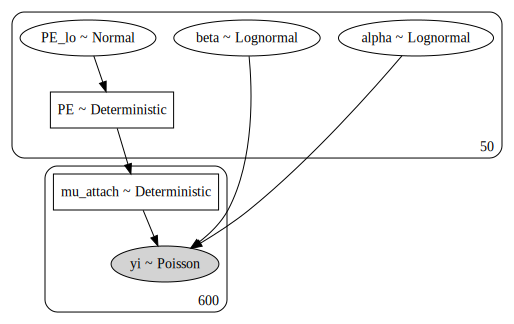

In [14]:
pm.model_to_graphviz(hm_test)

In [15]:
with hm_test:
    trace_dhit = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, PE_lo]
Sampling 4 chains, 2 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.50draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### Unpooled model

In [17]:
import theano.tensor as tt
with pm.Model() as hm_test_up:
    PE_lo = pm.Normal('PE_lo',mu=-0.3, sd=3, shape=nexp)
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    
    LC50_l = pm.Normal("LC50_l", mu=np.log(0.2),sd=4,shape=nexp)
    LC50   = pm.Deterministic('LC50',tt.exp(LC50_l))
    #sfrac = pm.Beta('sfrac',1,35,shape=nexp)
    sfrac = pm.Deterministic('sfrac',tt.zeros(nexp))
    #LC50  = pm.Lognormal('LC50'   ,mu=np.log(2),sd=0.2,shape=nexp)
    slope  = pm.Lognormal('slope', mu=np.log(1),sd=0.2,shape=nexp)
    
    #nu     = pm.Lognormal('nu',    mu=np.log(1),sd=0.2,shape=nexp)
    nu_l = pm.Normal('nu_l',np.log(1),sd=0.2,shape=nexp)
    nu  = pm.Deterministic('nu',tt.exp(nu_l))
     

    model = pm.Deterministic('model',mu_attach*cu.sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx]) )
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [18]:
with hm_test_up:
    trace_up = pm.sample(start={'sfrac':0.02})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_l, slope, LC50_l, PE_lo]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 237.13draws/s]


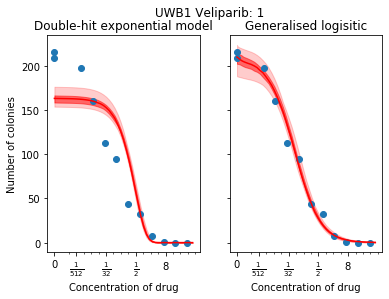

In [23]:
iplt=8
fig,axs = plt.subplots(1,2,sharex=True,sharey=True)
fig.suptitle( cu.get_exp_label(df,iplt))
ax = axs[0]
ax.set_title('Double-hit exponential model')
cu.posterior_comp(ax,df,trace_dhit,iplt)
ax.set_xscale('symlog', linthreshx=1E-3,basex=2)
ax.set_xlabel("Concentration of drug")
ax.set_ylabel("Number of colonies")

formatter = FuncFormatter(cu.pow2formatter)
ax.xaxis.set_major_formatter(formatter);
locs = [0]+[2**n for n in range(-9,4,4)]
ax.set_xticks(locs);

ax =axs[1]
ax.set_title('Generalised logisitic')
cu.posterior_comp_sigmoid(ax,df,trace_up,iplt)
ax.set_xlabel("Concentration of drug");


### Pooled model

In [24]:
ncell = len(df['i_cell'].unique())
ndrug = len(df['i_drug'].unique())
ndrugcell = len(df['i_drugcell'].unique())
import theano.tensor as tt
with pm.Model() as hm_test:
    vdict={}
    # plating efficenct
    PE_lo_mu = pm.Normal    ('PE_lo_mu',mu=-1, sd=3, shape=ncell)
    PE_lo_sd = pm.HalfNormal('PE_lo_sd',sd=0.2,      shape=ncell)
    
    PE_lo = pm.Deterministic('PE_lo',            PE_lo_mu[cell2ind]+\
        pm.Normal("PE_lod",mu=0,sd=1,shape=nexp)*PE_lo_sd[cell2ind])
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    # drugs have common dist
    pu.add_2level_hierarchy('LC50_l',vdict, np.log(0.1),5., 0.1, 0.05,  drugcell2ind)
    LC50 = pm.Deterministic('LC50', tt.exp(vdict['LC50_l']))
    
    pu.add_2level_hierarchy('slope_l', vdict, np.log(0.15),0.4, 0.2, 0.1, drugcell2ind)
    slope= pm.Deterministic('slope',tt.exp(vdict['slope_l']))
        
    pu.add_2level_hierarchy('nu_l', vdict, np.log(1),0.2, 0.1, 0.1, drugcell2ind)
    nu= pm.Deterministic('nu',tt.exp(vdict['nu_l']))  
    
    if( False):
        sfrac_lo_mu = pm.Normal    ('sfrac_lo_mu',mu=np.log(0.02), sd=1, shape=ndrugcell)
        sfrac_lo_sd = pm.HalfNormal('sfrac_lo_sd',sd=0.05,      shape=ndrugcell)
    
        sfrac_lo = pm.Deterministic('sfrac_lo',      sfrac_lo_mu[drugcell2ind]+\
         pm.Normal("sfrac_lod",mu=0,sd=1,shape=nexp)*sfrac_lo_sd[drugcell2ind])
    
        
        sfrac    = pm.Deterministic('sfrac', invlogit(sfrac_lo) )
    sfrac_l = pu.add_2level_hierarchy('sfrac_l',vdict, np.log(0.02),0.2,0.1,0.1,drugcell2ind)
    sfrac = pm.Deterministic('sfrac',tt.exp(vdict['sfrac_l']))
    #sfrac = pm.Deterministic('sfrac',tt.zeros(nexp))

    

    #model = pm.Deterministic('model',mu_attach*
    #                          cu.sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx]) )
    model = mu_attach* cu.sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx])
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [25]:
with hm_test:
    trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dsfrac_l_l0c, dsfrac_l_l0ss, dsfrac_l_l1c, dsfrac_l_l1s, sfrac_l_l2, dnu_l_l0c, dnu_l_l0ss, dnu_l_l1c, dnu_l_l1s, nu_l_l2, dslope_l_l0c, dslope_l_l0ss, dslope_l_l1c, dslope_l_l1s, slope_l_l2, dLC50_l_l0c, dLC50_l_l0ss, dLC50_l_l1c, dLC50_l_l1s, LC50_l_l2, PE_lod, PE_lo_sd, PE_lo_mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [01:42<00:00, 58.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


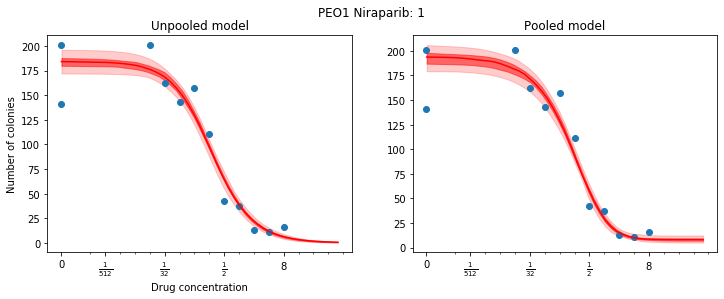

In [30]:
iplt=cu.get_exp_index(df,'Niraparib','PEO1',2)
fig,axs = plt.subplots(1,2,sharex=True,figsize=(12,4))
fig.suptitle(cu.get_exp_label(df,iplt))
ax=axs[0]
ax.set_title("Unpooled model")
cu.posterior_comp_sigmoid(ax,df,trace_up,iplt)
ax.set_ylabel("Number of colonies")
ax.set_xlabel("Drug concentration")

ax=axs[1]
ax.set_title("Pooled model")
cu.posterior_comp_sigmoid(ax,df,trace,   iplt)

ax.set_xscale('symlog', linthreshx=1E-3,basex=2)
formatter = FuncFormatter(cu.pow2formatter)
ax.xaxis.set_major_formatter(formatter);
locs = [0]+[2**n for n in range(-9,4,4)]
ax.set_xticks(locs);




0.41270759203111695


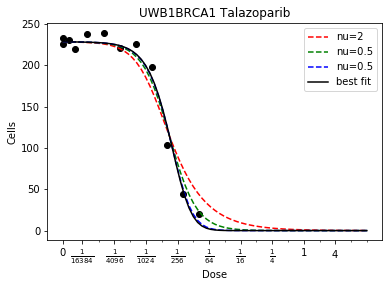

In [33]:
iplt=15

fig,ax = plt.subplots(1,1)
dft = df[df['i_exp']==iplt]
ax.plot( dft['Treatment'],dft['Count'],'o',color='k')

ax.set_xscale('symlog', linthreshx=1E-4,basex=2)
formatter = FuncFormatter(cu.pow2formatter)
ax.xaxis.set_major_formatter(formatter);
locs = [0]+[2**n for n in range(-14,4,2)]
ax.set_xticks(locs);


PE = np.median(trace.get_values('PE')[:,iplt])
LC50= np.median(trace.get_values('LC50')[:,iplt])
slope= np.median(trace.get_values('slope')[:,iplt])
nu = np.median(trace.get_values('nu')[:,iplt])
cp=dft['Cells Plated'].median()
print(nu)
xp =np.array([0.]+[2**n for n in np.linspace(-18,4,81)])

choice='nu'
if( choice=='LC50'):
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,2**-2, slope,nu),color='red' ,ls='--',label=r'LC50$=2^{-8}$')
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, slope,nu),color='green' ,label='best fit')
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,2**-4, slope,nu),color='blue' ,ls='--',label=r'LC50$=2^{-10}$')
if( choice=='slope'):
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, 2,nu),color='red' ,ls='--',label='slope=2')
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, slope,nu),color='green' ,label='best fit')
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, 1,nu),color='blue' ,ls='--',label='slope=1')
if( choice=='nu'):
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, slope,2),color='red' ,ls='--',label='nu=2')    
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, slope,1),color='green' ,ls='--',label='nu=0.5')
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, slope,0.5),color='blue' ,ls='--',label='nu=0.5')
    plt.plot(xp,cp*PE*cu.sigmoid_curve(xp,0.,LC50, slope,nu),color='k' ,label='best fit')
    
drug = dft['Drug'].values[0]
cell_line = dft['Cell_line'].values[0]
ax.set_title("{} {}".format(cell_line,drug))
ax.legend()
ax.set_xlabel("Dose")
ax.set_ylabel("Cells");

In [35]:
# get the order of the drugs LC50, we will order the plots by these 
lc50s = np.median(trace.get_values('dLC50_l_l1'),axis=0)
lc50_d = np.zeros(len(np.unique(drug2drugcell)) )
for i in np.unique(drug2drugcell):
    lc50_d[i]=np.average( lc50s[drug2drugcell==i] )
isort = np.argsort(lc50_d)
drugnames = df['Drug'].unique()
drugsort=drugnames[isort]

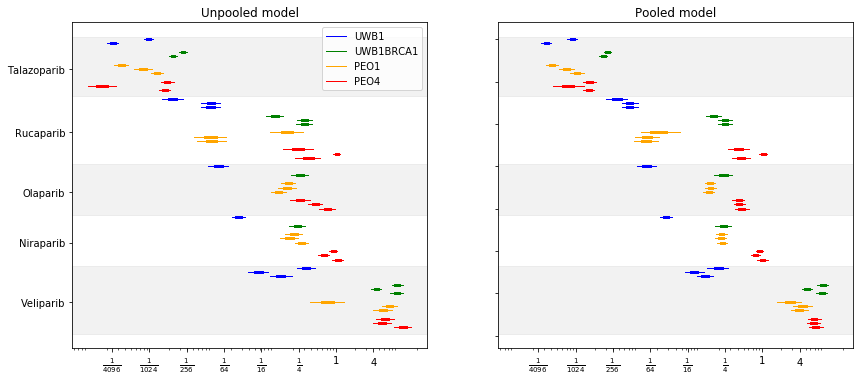

In [37]:
fig,axs = plt.subplots(1,2,figsize=(14,6),sharex=True)
ax = axs[0]
ax.set_title('Unpooled model')
cu.var_comp(ax,df,trace_up,'LC50',drugs=drugsort,legend='upper right',label_plate=False)
ax = axs[1]
ax.set_title('Pooled model')
cu.var_comp(ax,df,trace   ,'LC50',drugs=drugsort,label=False)
axs[0].set_xscale('log')
cu.set_pow2format(axs[0],[2**n for n in range(-12,3,2)])

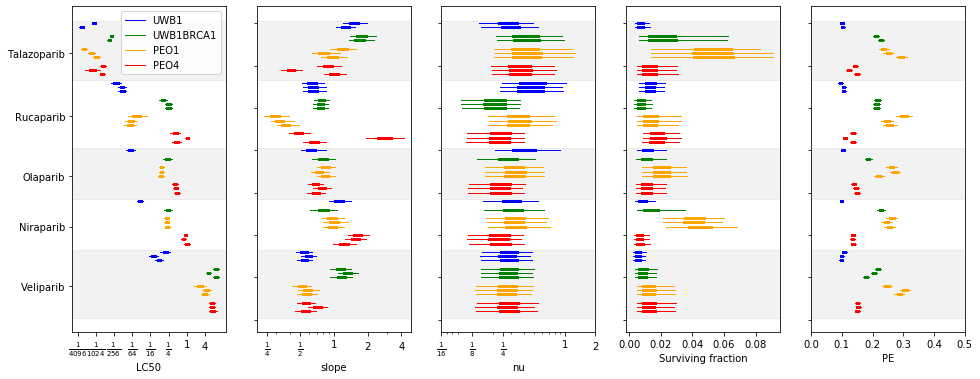

In [39]:
fig,axs = plt.subplots(1,5,figsize=(16,6))

axs[0].set_xlabel('LC50')
cu.var_comp(axs[0],df,trace,'LC50',drugs=drugsort,legend='upper right')
axs[0].set_xscale('log')
cu.set_pow2format(axs[0],[2**n for n in range(-12,3,2)])

axs[1].set_xlabel('slope')
cu.var_comp(axs[1],df,trace   ,'slope',drugs=drugsort,label=False)
axs[1].set_xscale('log')
cu.set_pow2format(axs[1],[0.25,0.5,1,2,4])

axs[2].set_xlabel('nu')
cu.var_comp(axs[2],df,trace   ,'nu',drugs=drugsort,label=False)
axs[2].set_xscale('log')
cu.set_pow2format(axs[2],[1/16.,1/8.,1/4.,1,2])

axs[3].set_xlabel('Surviving fraction')
cu.var_comp(axs[3],df,trace,'sfrac',drugs=drugsort,label=False)

axs[4].set_xlabel('PE')
axs[4].set_xlim(0,0.5)
cu.var_comp(axs[4],df,trace,'PE', drugs=drugsort,label=False)



([-1.5, -5.5, -9.5, -13.5, -17.5],
 array(['Talazoparib', 'Rucaparib', 'Olaparib', 'Niraparib', 'Veliparib'],
       dtype=object))

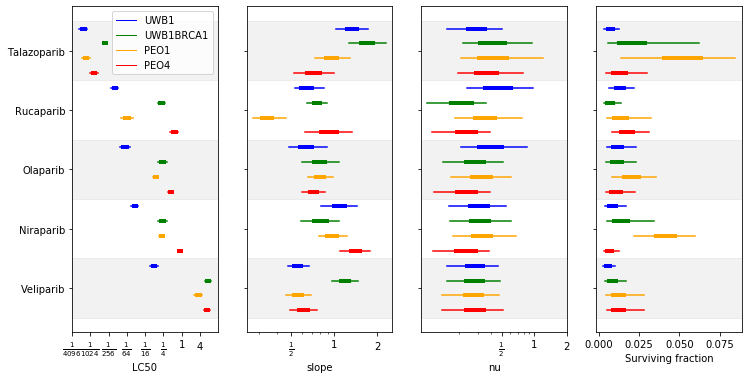

In [44]:
fig,axs = plt.subplots(1,4,figsize=(12,6))

ax=axs[0]
ax.set_xlabel("LC50")
cu.var_comp_level1(ax,df,trace,'LC50_l',transform=np.exp, drugs=drugsort, legend='upper right')
ax.set_xscale('log')
cu.set_pow2format(ax,[2**n for n in range(-12,3,2)])

ax=axs[1]
ax.set_xlabel("slope")
cu.var_comp_level1(ax,df,trace,'slope_l',transform=np.exp,drugs=drugsort, label=False)
ax.set_xscale('log')
cu.set_pow2format(ax,[2**n for n in range(-1,2,1)])

ax=axs[2]
ax.set_xlabel("nu")
cu.var_comp_level1(ax,df,trace,'nu_l',transform=np.exp,drugs=drugsort, label=False)
ax.set_xscale('log')
cu.set_pow2format(ax,[2**n for n in range(-1,2,1)])

ax=axs[3]
ax.set_xlabel("Surviving fraction")
cu.var_comp_level1(ax,df,trace,'sfrac_l',transform=np.exp  ,drugs=drugsort, label=False)

